# LLM with RAG (Retrieval Augmented Generation)

**LLM (Large Language Models):**

LLMs, like GPT-3 (Generative Pre-trained Transformer 3), are based on transformer architectures. Transformers have encoder and decoder components, each with self-attention mechanisms.
GPT-3, as a type of LLM, is capable of various language tasks, including question answering, and is a powerful language model developed by OpenAI. 

Large language models confront several **challenges** related to the accuracy and currency of their knowledge. Two common issues are hallucination and knowledge cut-off.

**Hallucination:** It occurs when a model confidently produces an incorrect response. For instance, if a model claims ‘googly retriever’ is a real dog breed, it’s a hallucination, potentially leading to misleading information.

**Knowledge cut-off:** "As of my last knowledge update in January 2022, the term "xxxxx" doesn't have a specific and widely recognized meaning in a general context. It could refer to different things depending on the context in which it is used."


# Solution: Retrieval Augmented Generation
RAG is a technique designed to enhance LLMs like GPT-3 by incorporating a retriever component.It enhances the capabilities of LLMs by allowing them to retrieve information from external sources during the generation process. This not only helps in reducing hallucinations by grounding responses in real-world data but also overcomes knowledge cut-offs by incorporating current information from external data sources. If we want to create an application to chat with our data, we need to first load our data into a format where it can be worked with.


To efficiently retrieve information from documents, a common practice is to index them in a **vector database**, using **embedding vectors** that capture semantic **meaning**. Additionally, **chunking** is applied to large documents to improve relevance and reduce noise, ultimately enhancing the model’s responses by providing specific contextual information.


### Key components:
**Generator:**
The generator is a language model, often a variant of a large pre-trained model like GPT (Generative Pre-trained Transformer).
It is responsible for generating text based on the input it receives and the information retrieved by the retriever component.

**Retriever:**
The retriever is a component that is responsible for fetching relevant information from external data sources.
It helps the model access a broader range of information beyond what is present in its pre-training data.
The retriever might use techniques like information retrieval, document retrieval, or database queries to extract relevant data.

**Context Integration:**
RAG integrates the retrieved information into the generation process of the language model.
The retrieved context is used to enhance the quality and accuracy of the generated text.
This integration helps mitigate hallucinations and ensures that the generated content is grounded in real-world information.

**Dual-Process Architecture:**
RAG often employs a dual-process architecture, where the language model and the retriever operate in tandem.
The retriever provides context or information to the generator, and the generator utilizes this information to produce coherent and contextually relevant responses.

**Training Pipeline:**
RAG is trained through a process that involves training the language model and the retriever component separately.
The training pipeline may include stages where the retriever is fine-tuned to improve its ability to fetch relevant information.


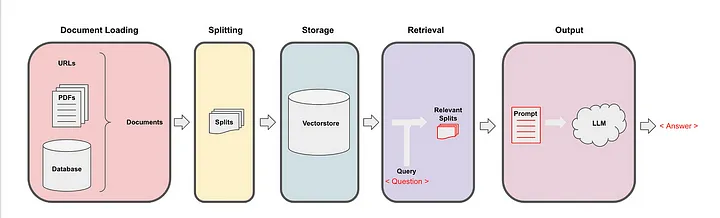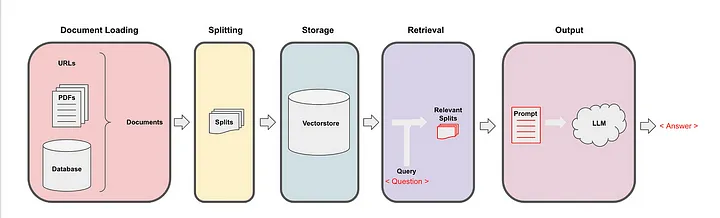
reference: https://medium.com/international-school-of-ai-data-science/efficient-information-retrieval-with-rag-workflow-afdfc2619171


**LangChain**, a comprehensive platform for natural language processing, plays a pivotal role in making RAG models accessible and efficient. 

**Document Loaders and Transformers**
The Document Transformers component is responsible for preparing these documents for retrieval, including splitting large documents into smaller, more manageable chunks.

**Text Embedding Models**
These models create vector representations of text, capturing its semantic meaning. This vectorization enables efficient retrieval of similar pieces of text.

**Vector Stores**
With the rise of embeddings, efficient databases are needed for storing and searching these embeddings.

**Retrievers**
Retrievers in LangChain provide the interface to retrieve documents relevant to a query. 

**Caching Embeddings**
LangChain’s Caching Embeddings feature allows embeddings to be stored or temporarily cached, reducing the need for recomputation and improving overall performance.


**Integration with Hugging Face**
Hugging Face, a leading platform for transformer-based models, provides pre-trained models, including the ones used in RAG. LangChain seamlessly integrates with Hugging Face’s models, enabling you to fine-tune and adapt them for your specific tasks.



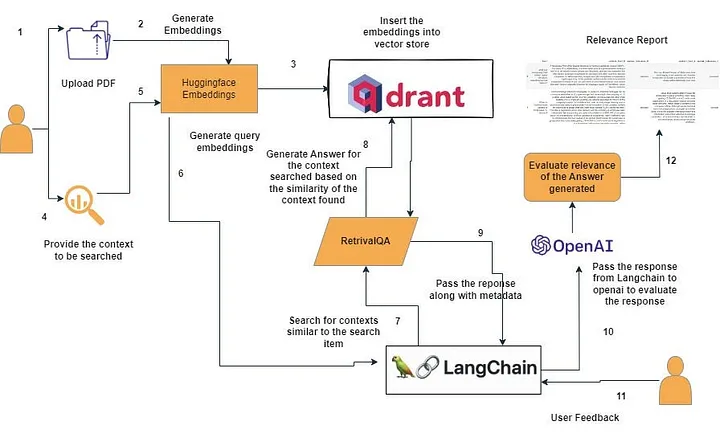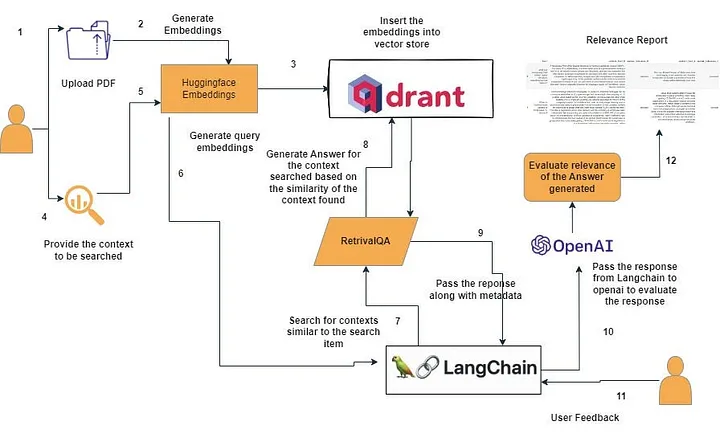
- reference: https://medium.com/international-school-of-ai-data-science/efficient-information-retrieval-with-rag-workflow-afdfc2619171

In [22]:
# !pip install -q langchain
# !pip install -q torch
# !pip install -q transformers
# !pip install -q sentence-transformers
# !pip install -q datasets
# !pip install -q faiss-cpu

In [23]:
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline


# Document Loading
We use LangChain’s document loaders. These documents come in different data types, like pdf, html, json, word, and PowerPoint or can be in tabular format. Document loaders take in data from these data sources and load them into a standard document object 

In [24]:
# IMPORT DATASET
# Specify the dataset name and the column containing the content
dataset_name = "databricks/databricks-dolly-15k"
page_content_column = "context"  # or any other column you're interested in

# Create a loader instance
loader = HuggingFaceDatasetLoader(dataset_name, page_content_column)

# Load the data
data = loader.load()

# Display the first 15 entries
data[:2]

/Users/burcuozek/opt/anaconda3/envs/LLM/lib/python3.8/site-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


[Document(page_content='"Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia\'s domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."', metadata={'instruction': 'When did Virgin Australia start operating?', 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'}),
 Document(page_content='""', metadata={'instruction': 'Which is a species of fish? Tope or Rope', 'response': 'Tope', 'category': 'classification'})]

# Document Splitting
If these documents are large, we need to split them up into smaller chunks because we need to retrieve only those pieces of content that are most relevant to us.

There are different ways of document splitting, such as Recursive Text Splitter, Character Text Splitter, and Character Text Splitter with separator defined.

We can also split Token splitting, Context-aware splitting

In [25]:
# Create an instance of the RecursiveCharacterTextSplitter class with specific parameters.
# It splits text into chunks of 1000 characters each with a 150-character overlap.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)

# 'data' holds the text you want to split, split the text into documents using the text splitter.
docs = text_splitter.split_documents(data)

In [26]:
docs[0]

Document(page_content='"Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia\'s domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney."', metadata={'instruction': 'When did Virgin Australia start operating?', 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa'})

# Vector Stores and Text Embeddings

We move these chunks of data into a vector store

Vector stores and embeddings come after text splitting as we need to store our documents in an easily accessible format. **Embeddings** take a piece of text and create a **numerical representation of the text**. Thus, text with **semantically** similar content will have similar vectors in embedding space. Thus, we can compare embeddings(vectors) and find texts that are similar.

The whole pipeline starts with documents. We split these documents into smaller splits and create embeddings of those splits or documents. Finally, we **store** all these embeddings in a **vector store**, which is a database where we can easily look up similar vectors later on. This is useful when we try to find documents that are relevant to a question.



In [27]:
# Define the path to the pre-trained model you want to use
modelPath = "sentence-transformers/all-MiniLM-l6-v2"

# Create a dictionary with model configuration options, specifying to use the CPU for computations
model_kwargs = {'device':'cpu'}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': False}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

In [28]:
# Define the path to the pre-trained model you want to use
modelPath = "sentence-transformers/all-MiniLM-l6-v2"

# Create a dictionary with model configuration options, specifying to use the CPU for computations
model_kwargs = {'device':'cpu'}

# Create a dictionary with encoding options, specifically setting 'normalize_embeddings' to False
encode_kwargs = {'normalize_embeddings': False}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

In [29]:
text = "This is a test document."
query_result = embeddings.embed_query(text)
query_result[:3]

[-0.0383385494351387, 0.12346471101045609, -0.028642969205975533]

### Vector Stores
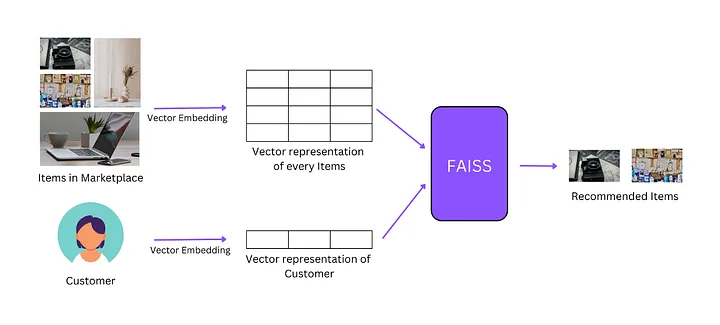

In [30]:
# This takes long, don't worry
db = FAISS.from_documents(docs, embeddings)

### Retrieval Techniques:


1. Accessing/indexing data in the vector store
- Basic semantic similarity
    
    (The semantic search worked pretty well for a good amount of use cases. But it fails for some edge cases (e.g., duplicate chunks - does not enforce diversity. There are few different and more advanced methods to overcome these edge cases:)

- Maximum Marginal Relevance (it helps to select a diverse set of documents.)
- Including Metadata (it helps to address specificity in the search. Query “What did they say about regression in the third lecture?” returned results not just from the third lecture but also from the first and second lectures)

2. LLM-aided retrieval (when we want to infer metadata from the query itself)

3. Contextual Compression (With compression, we run all our documents through a language model and extract the most relevant segments and then pass only the most relevant segments into a final language model call.)


### eg.: 1 - Similarity Search

You can find relevant documents using the following code, but if there is no information about the question in the text, this won't provide an answer.

In [31]:
question = "What is cheesemaking?"
searchDocs = db.similarity_search(question)
# docs = vectordb.similarity_search(question,k=3) # when we want to specify how many documents we should print k = 3
print(searchDocs[0].page_content)

"The goal of cheese making is to control the spoiling of milk into cheese. The milk is traditionally from a cow, goat, sheep or buffalo, although, in theory, cheese could be made from the milk of any mammal. Cow's milk is most commonly used worldwide. The cheesemaker's goal is a consistent product with specific characteristics (appearance, aroma, taste, texture). The process used to make a Camembert will be similar to, but not quite the same as, that used to make Cheddar.\n\nSome cheeses may be deliberately left to ferment from naturally airborne spores and bacteria; this approach generally leads to a less consistent product but one that is valuable in a niche market.\n\nCulturing\nCheese is made by bringing milk (possibly pasteurised) in the cheese vat to a temperature required to promote the growth of the bacteria that feed on lactose and thus ferment the lactose into lactic acid. These bacteria in the milk may be wild, as is the case with unpasteurised milk, added from a culture,


# Question Answering
We have discussed how to do question answering with the documents that we have just retrieved in Retrieval. 

Now, we take these documents and the original question, pass both to a language model, and ask the language model to answer the question.

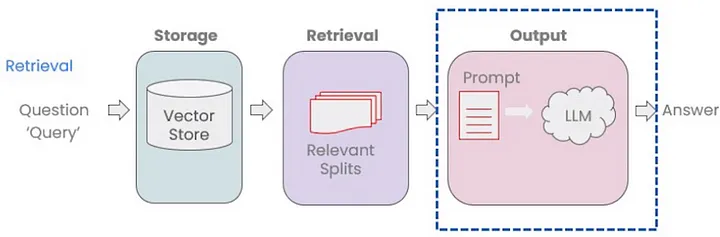


In [ ]:
# Create a tokenizer object by loading the pretrained "Intel/dynamic_tinybert" tokenizer.
tokenizer = AutoTokenizer.from_pretrained("Intel/dynamic_tinybert")

# Create a question-answering model object by loading the pretrained "Intel/dynamic_tinybert" model.
model = AutoModelForQuestionAnswering.from_pretrained("Intel/dynamic_tinybert")

# Specify the model name you want to use
model_name = "Intel/dynamic_tinybert"

# Load the tokenizer associated with the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, truncation=True, max_length=512)

# Define a question-answering pipeline using the model and tokenizer
question_answerer = pipeline(
    "question-answering", 
    model=model_name, 
    tokenizer=tokenizer,
    return_tensors='pt'
)

# Create an instance of the HuggingFacePipeline, which wraps the question-answering pipeline
# with additional model-specific arguments (temperature and max_length)
llm = HuggingFacePipeline(
    pipeline=question_answerer,
    model_kwargs={"temperature": 0.7, "max_length": 512},
)

In [36]:
# Create a retriever object from the 'db' with a search configuration where it retrieves up to 4 relevant splits/documents.
retriever = db.as_retriever(search_kwargs={"k": 4})

# You can find relavent documents using the following code, but if there is no information about the question in the text, this won't answer
# docs = retriever.get_relevant_documents("What is Cheesemaking?")
# print(docs[0].page_content)


# Create a question-answering instance (qa) using the RetrievalQA class.
# It's configured with a language model (LLM), a chain type "refine," the retriever we created, and an option not to return source documents.

##### In here we use the 2- LLM - Self Query models #####

qa = RetrievalQA.from_chain_type(llm=llm, chain_type="refine", retriever=retriever, return_source_documents=False)

In [41]:
#### IGNORE THE ERROR AND CHECK THE ANSWER AT THE BOTTOM!!!!

question = "Who is Thomas Jefferson?"
result = qa.run({"query": question})
print(result["result"])
## Even if there is an error, you can ignore, at the end, you will see the answer. 

ValueError: Context information is below. 
------------
"Thomas Jefferson (April 13, 1743 \u2013 July 4, 1826) was an American statesman, diplomat, lawyer, architect, philosopher, and Founding Father who served as the third president of the United States from 1801 to 1809. Among the Committee of Five charged by the Second Continental Congress with authoring the Declaration of Independence, Jefferson was the Declaration's primary author. Following the American Revolutionary War and prior to becoming the nation's third president in 1801, Jefferson was the first United States secretary of state under George Washington and then the nation's second vice president under John Adams."
------------
Given the context information and not prior knowledge, answer the question: Who is Thomas Jefferson?
 argument needs to be of type (SquadExample, dict)

References: 
- https://medium.com/@onkarmishra/using-langchain-for-question-answering-on-own-data-3af0a82789ed
- https://medium.com/international-school-of-ai-data-science/implementing-rag-with-langchain-and-hugging-face-28e3ea66c5f7